# Generative Adversarial Networks

## Importing Libraries

In [1]:
!pip install -q pytorch-fid

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tqdm
import os
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
from pytorch_fid import fid_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)

## Setting up the GPU

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Preprocessing the Images

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Loading the Dataset

In [6]:
batch_size = 64

In [7]:
dataset = datasets.MNIST(root='./data/train', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 107135670.85it/s]


Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49022943.68it/s]


Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25951006.75it/s]


Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8881365.39it/s]


Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw



## Generator Network

In [8]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim=64):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 64*7*7), 
            nn.BatchNorm1d(64*7*7),
            nn.ReLU(),

            Reshape((-1, 16*4, 7, 7)),  # Reshape to be used in PixelShuffle
            nn.PixelShuffle(upscale_factor=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.PixelShuffle(upscale_factor=2),

            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        return z

## Discriminator Network

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Non_Saturating Loss

In [11]:
class NSLosses:
    def generator_loss(self, outputs):
        return -torch.mean(torch.log(outputs))

    def discriminator_loss(self, outputs_real, outputs_fake):
        loss_real = -torch.mean(torch.log(outputs_real))
        loss_fake = -torch.mean(torch.log(1.0 - outputs_fake))
        return loss_real + loss_fake

### Noise Generation from Normal Distribution

In [12]:
def generate_noise(batch_size, latent_dim=64):
    return torch.randn(batch_size, latent_dim).to(device)

### Initialize Models and Loss

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=3136, bias=True)
    (4): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Reshape()
    (7): PixelShuffle(upscale_factor=2)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): PixelShuffle(upscale_factor=2)
    (12): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, en

In [14]:
ns_losses = NSLosses()

### Set Loss and Optimizer

In [15]:
lr = 0.00005

In [16]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

## Training the Model

In [17]:
def plot_losses(losses_G, losses_D):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_D, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
def plot_generated_images(generator, epoch, epochs):
    with torch.no_grad():
        fake_images = generator(generate_noise(100)).detach().cpu()
    fake_images = fake_images.view(-1, 1, 28, 28)
    vutils.save_image(fake_images, f"gan_samples_epoch_{epoch}.png" ,nrow=10, normalize=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(vutils.make_grid(fake_images, nrow=10, normalize=True).permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Generated Images From Epoch {epoch + 1} / {epochs}")
    plt.show()

In [19]:
num_epochs = 80

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [1/80], D Loss: 0.04883012920618057, G Loss: 6.450540065765381


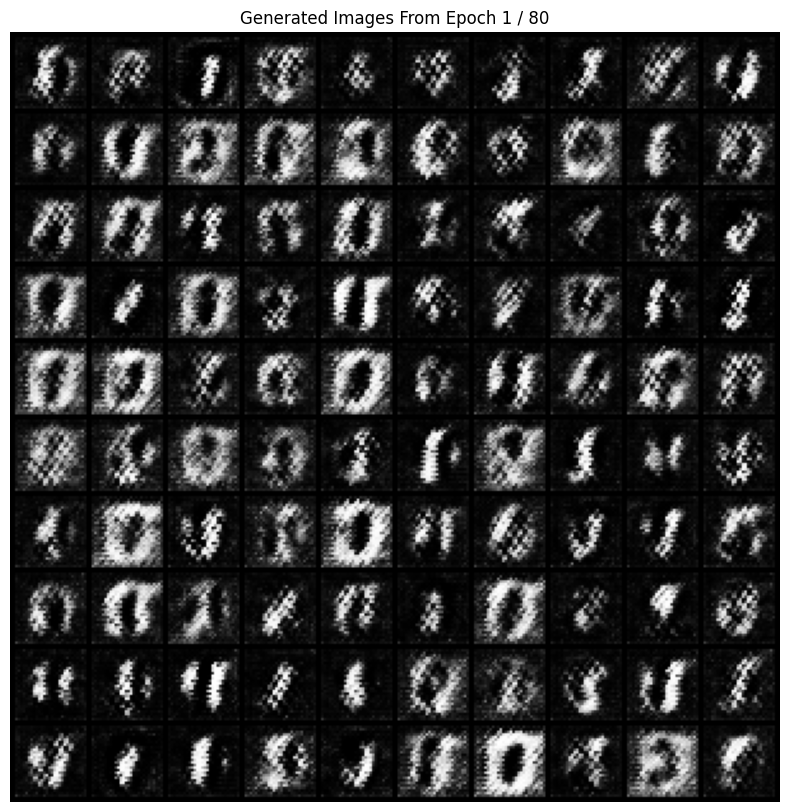

  2%|▎         | 2/80 [00:26<16:52, 12.98s/it]

Epoch [2/80], D Loss: 0.3501986861228943, G Loss: 3.5017406940460205


  4%|▍         | 3/80 [00:38<16:15, 12.67s/it]

Epoch [3/80], D Loss: 0.7012560367584229, G Loss: 1.917305588722229


  5%|▌         | 4/80 [00:50<15:43, 12.42s/it]

Epoch [4/80], D Loss: 0.6151527166366577, G Loss: 1.9786787033081055


  6%|▋         | 5/80 [01:02<15:23, 12.32s/it]

Epoch [5/80], D Loss: 0.7499563097953796, G Loss: 1.314634084701538


  8%|▊         | 6/80 [01:15<15:12, 12.33s/it]

Epoch [6/80], D Loss: 0.848785400390625, G Loss: 1.517634391784668


  9%|▉         | 7/80 [01:27<14:50, 12.19s/it]

Epoch [7/80], D Loss: 1.2074966430664062, G Loss: 1.0909854173660278


 10%|█         | 8/80 [01:39<14:33, 12.13s/it]

Epoch [8/80], D Loss: 0.8824558258056641, G Loss: 1.3705320358276367


 11%|█▏        | 9/80 [01:51<14:28, 12.23s/it]

Epoch [9/80], D Loss: 1.022918939590454, G Loss: 1.3797106742858887


 12%|█▎        | 10/80 [02:03<14:10, 12.14s/it]

Epoch [10/80], D Loss: 0.8200819492340088, G Loss: 1.1659836769104004


 14%|█▍        | 11/80 [02:15<13:59, 12.17s/it]

Epoch [11/80], D Loss: 0.9942833185195923, G Loss: 1.1867917776107788


 15%|█▌        | 12/80 [02:27<13:43, 12.10s/it]

Epoch [12/80], D Loss: 1.2806047201156616, G Loss: 0.8535621166229248


 16%|█▋        | 13/80 [02:39<13:30, 12.09s/it]

Epoch [13/80], D Loss: 0.9715336561203003, G Loss: 1.0327889919281006


 18%|█▊        | 14/80 [02:51<13:17, 12.09s/it]

Epoch [14/80], D Loss: 1.085278034210205, G Loss: 0.8062294125556946


 19%|█▉        | 15/80 [03:03<13:06, 12.11s/it]

Epoch [15/80], D Loss: 1.0387442111968994, G Loss: 1.0331292152404785


 20%|██        | 16/80 [03:15<12:52, 12.07s/it]

Epoch [16/80], D Loss: 1.2314571142196655, G Loss: 1.586819052696228


 21%|██▏       | 17/80 [03:28<12:43, 12.12s/it]

Epoch [17/80], D Loss: 1.082099199295044, G Loss: 1.4670538902282715


 22%|██▎       | 18/80 [03:40<12:29, 12.09s/it]

Epoch [18/80], D Loss: 1.0684058666229248, G Loss: 1.2329919338226318


 24%|██▍       | 19/80 [03:52<12:21, 12.15s/it]

Epoch [19/80], D Loss: 1.1246869564056396, G Loss: 1.217017650604248


 25%|██▌       | 20/80 [04:04<12:08, 12.15s/it]

Epoch [20/80], D Loss: 1.0839265584945679, G Loss: 1.3167685270309448


 26%|██▋       | 21/80 [04:16<11:54, 12.10s/it]

Epoch [21/80], D Loss: 0.9866938591003418, G Loss: 1.495175838470459


 28%|██▊       | 22/80 [04:29<11:50, 12.25s/it]

Epoch [22/80], D Loss: 0.9414504766464233, G Loss: 0.9629408717155457


 29%|██▉       | 23/80 [04:41<11:32, 12.16s/it]

Epoch [23/80], D Loss: 0.8715461492538452, G Loss: 1.1241204738616943


 30%|███       | 24/80 [04:53<11:17, 12.11s/it]

Epoch [24/80], D Loss: 1.0834314823150635, G Loss: 1.1467809677124023


 31%|███▏      | 25/80 [05:05<11:04, 12.07s/it]

Epoch [25/80], D Loss: 1.1339812278747559, G Loss: 1.1164135932922363


 32%|███▎      | 26/80 [05:16<10:47, 11.99s/it]

Epoch [26/80], D Loss: 1.0634592771530151, G Loss: 1.4408396482467651


 34%|███▍      | 27/80 [05:29<10:36, 12.01s/it]

Epoch [27/80], D Loss: 0.8924239277839661, G Loss: 0.8589813113212585


 35%|███▌      | 28/80 [05:40<10:23, 11.99s/it]

Epoch [28/80], D Loss: 1.032059907913208, G Loss: 0.919546365737915


 36%|███▋      | 29/80 [05:52<10:11, 11.99s/it]

Epoch [29/80], D Loss: 1.0029938220977783, G Loss: 0.8225575685501099


 38%|███▊      | 30/80 [06:05<10:02, 12.05s/it]

Epoch [30/80], D Loss: 1.176243782043457, G Loss: 1.4588162899017334


 39%|███▉      | 31/80 [06:17<09:50, 12.05s/it]

Epoch [31/80], D Loss: 1.0913087129592896, G Loss: 1.3887181282043457


 40%|████      | 32/80 [06:29<09:42, 12.13s/it]

Epoch [32/80], D Loss: 1.018047571182251, G Loss: 1.3847427368164062


 41%|████▏     | 33/80 [06:41<09:29, 12.11s/it]

Epoch [33/80], D Loss: 1.048486351966858, G Loss: 1.509800672531128


 42%|████▎     | 34/80 [06:53<09:14, 12.06s/it]

Epoch [34/80], D Loss: 0.8932603597640991, G Loss: 1.1072757244110107


 44%|████▍     | 35/80 [07:05<09:03, 12.08s/it]

Epoch [35/80], D Loss: 0.9631179571151733, G Loss: 1.3210967779159546


 45%|████▌     | 36/80 [07:17<08:48, 12.00s/it]

Epoch [36/80], D Loss: 0.9035525321960449, G Loss: 0.9431992173194885


 46%|████▋     | 37/80 [07:29<08:38, 12.05s/it]

Epoch [37/80], D Loss: 1.0560647249221802, G Loss: 1.0771243572235107


 48%|████▊     | 38/80 [07:41<08:26, 12.07s/it]

Epoch [38/80], D Loss: 1.0600166320800781, G Loss: 1.1828209161758423


 49%|████▉     | 39/80 [07:53<08:12, 12.02s/it]

Epoch [39/80], D Loss: 1.1778539419174194, G Loss: 0.9295903444290161


 50%|█████     | 40/80 [08:05<08:02, 12.06s/it]

Epoch [40/80], D Loss: 1.0631225109100342, G Loss: 1.939040184020996
Epoch [41/80], D Loss: 1.0001848936080933, G Loss: 1.4693034887313843


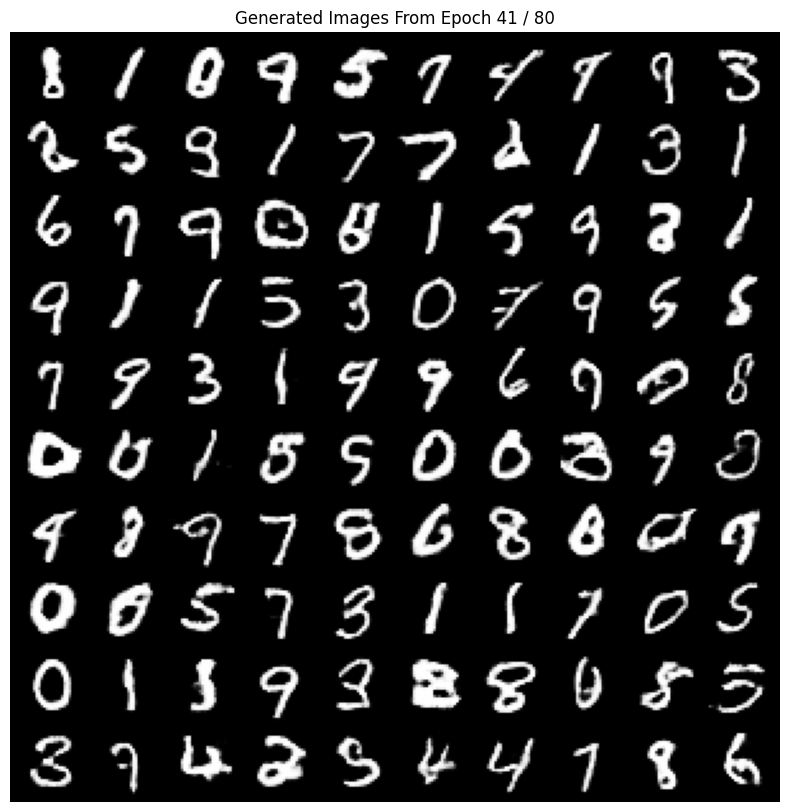

 52%|█████▎    | 42/80 [08:29<07:36, 12.02s/it]

Epoch [42/80], D Loss: 0.9437201023101807, G Loss: 1.2673602104187012


 54%|█████▍    | 43/80 [08:42<07:26, 12.06s/it]

Epoch [43/80], D Loss: 0.9109605550765991, G Loss: 1.0017573833465576


 55%|█████▌    | 44/80 [08:53<07:12, 12.01s/it]

Epoch [44/80], D Loss: 0.7845309376716614, G Loss: 1.3858951330184937


 56%|█████▋    | 45/80 [09:05<06:59, 11.99s/it]

Epoch [45/80], D Loss: 0.8507562875747681, G Loss: 1.1682896614074707


 57%|█████▊    | 46/80 [09:17<06:48, 12.03s/it]

Epoch [46/80], D Loss: 0.9847385883331299, G Loss: 1.087106466293335


 59%|█████▉    | 47/80 [09:29<06:35, 11.98s/it]

Epoch [47/80], D Loss: 0.9411691427230835, G Loss: 0.6848254799842834


 60%|██████    | 48/80 [09:41<06:24, 12.01s/it]

Epoch [48/80], D Loss: 1.0290329456329346, G Loss: 1.2329635620117188


 61%|██████▏   | 49/80 [09:53<06:11, 11.98s/it]

Epoch [49/80], D Loss: 0.9702993035316467, G Loss: 0.8466576337814331


 62%|██████▎   | 50/80 [10:05<05:59, 11.99s/it]

Epoch [50/80], D Loss: 0.8935912251472473, G Loss: 1.2202420234680176


 64%|██████▍   | 51/80 [10:17<05:49, 12.04s/it]

Epoch [51/80], D Loss: 1.022550106048584, G Loss: 1.2325642108917236


 65%|██████▌   | 52/80 [10:30<05:37, 12.04s/it]

Epoch [52/80], D Loss: 1.0811138153076172, G Loss: 1.3978224992752075


 66%|██████▋   | 53/80 [10:42<05:25, 12.04s/it]

Epoch [53/80], D Loss: 1.0231363773345947, G Loss: 1.2370104789733887


 68%|██████▊   | 54/80 [10:54<05:12, 12.03s/it]

Epoch [54/80], D Loss: 0.8524045944213867, G Loss: 0.9869585037231445


 69%|██████▉   | 55/80 [11:06<05:00, 12.02s/it]

Epoch [55/80], D Loss: 0.9344174861907959, G Loss: 1.1060353517532349


 70%|███████   | 56/80 [11:18<04:49, 12.05s/it]

Epoch [56/80], D Loss: 1.0378961563110352, G Loss: 0.9746626615524292


 71%|███████▏  | 57/80 [11:30<04:35, 11.98s/it]

Epoch [57/80], D Loss: 0.9717603921890259, G Loss: 0.9570983648300171


 72%|███████▎  | 58/80 [11:42<04:24, 12.01s/it]

Epoch [58/80], D Loss: 1.0039901733398438, G Loss: 1.447819471359253


 74%|███████▍  | 59/80 [11:54<04:13, 12.06s/it]

Epoch [59/80], D Loss: 0.9551091194152832, G Loss: 1.1371395587921143


 75%|███████▌  | 60/80 [12:06<04:00, 12.04s/it]

Epoch [60/80], D Loss: 1.0677711963653564, G Loss: 1.1111866235733032


 76%|███████▋  | 61/80 [12:18<03:47, 12.00s/it]

Epoch [61/80], D Loss: 1.1055784225463867, G Loss: 1.261432409286499


 78%|███████▊  | 62/80 [12:30<03:37, 12.06s/it]

Epoch [62/80], D Loss: 0.8627715110778809, G Loss: 0.9021041393280029


 79%|███████▉  | 63/80 [12:42<03:24, 12.04s/it]

Epoch [63/80], D Loss: 1.0510594844818115, G Loss: 1.0533902645111084


 80%|████████  | 64/80 [12:54<03:13, 12.08s/it]

Epoch [64/80], D Loss: 1.110549807548523, G Loss: 1.5287812948226929


 81%|████████▏ | 65/80 [13:06<03:01, 12.10s/it]

Epoch [65/80], D Loss: 1.0433897972106934, G Loss: 1.948538064956665


 82%|████████▎ | 66/80 [13:18<02:49, 12.07s/it]

Epoch [66/80], D Loss: 0.9804024696350098, G Loss: 1.561476707458496


 84%|████████▍ | 67/80 [13:31<02:38, 12.16s/it]

Epoch [67/80], D Loss: 0.9926084876060486, G Loss: 1.0121127367019653


 85%|████████▌ | 68/80 [13:43<02:25, 12.12s/it]

Epoch [68/80], D Loss: 1.074878454208374, G Loss: 1.215878963470459


 86%|████████▋ | 69/80 [13:55<02:14, 12.19s/it]

Epoch [69/80], D Loss: 0.9116095900535583, G Loss: 1.4459527730941772


 88%|████████▊ | 70/80 [14:07<02:01, 12.13s/it]

Epoch [70/80], D Loss: 0.8651248216629028, G Loss: 1.1222507953643799


 89%|████████▉ | 71/80 [14:19<01:48, 12.08s/it]

Epoch [71/80], D Loss: 1.2521610260009766, G Loss: 1.2638286352157593


 90%|█████████ | 72/80 [14:31<01:36, 12.09s/it]

Epoch [72/80], D Loss: 0.9084262847900391, G Loss: 1.4313578605651855


 91%|█████████▏| 73/80 [14:43<01:23, 11.99s/it]

Epoch [73/80], D Loss: 1.0960052013397217, G Loss: 1.4772896766662598


 92%|█████████▎| 74/80 [14:55<01:12, 12.01s/it]

Epoch [74/80], D Loss: 0.8688733577728271, G Loss: 0.8578516244888306


 94%|█████████▍| 75/80 [15:07<01:00, 12.09s/it]

Epoch [75/80], D Loss: 0.896297812461853, G Loss: 1.2833175659179688


 95%|█████████▌| 76/80 [15:19<00:48, 12.02s/it]

Epoch [76/80], D Loss: 1.0475257635116577, G Loss: 0.46508049964904785


 96%|█████████▋| 77/80 [15:31<00:36, 12.06s/it]

Epoch [77/80], D Loss: 1.0790786743164062, G Loss: 1.28228759765625


 98%|█████████▊| 78/80 [15:43<00:23, 11.99s/it]

Epoch [78/80], D Loss: 0.9440028667449951, G Loss: 1.1690804958343506


 99%|█████████▉| 79/80 [15:55<00:11, 11.99s/it]

Epoch [79/80], D Loss: 1.1417804956436157, G Loss: 1.1698803901672363


100%|██████████| 80/80 [16:07<00:00, 12.09s/it]

Epoch [80/80], D Loss: 1.0079741477966309, G Loss: 1.2017838954925537


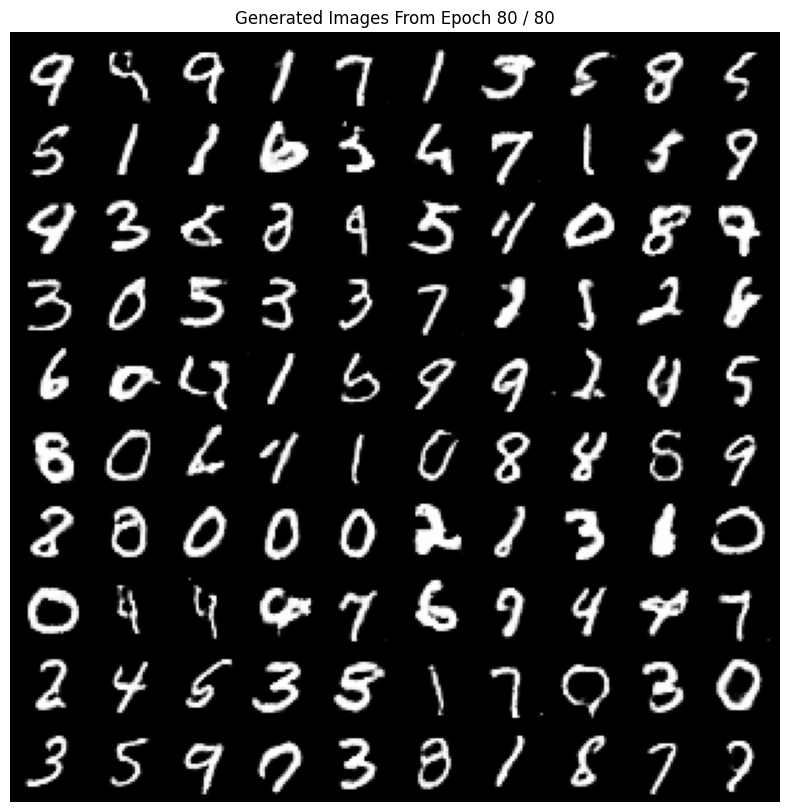

In [20]:
losses_G = []
losses_D = []

for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        size = real_images.shape[0]

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(size, 1).to(device)
        fake_labels = torch.zeros(size, 1).to(device)

        # Discriminator on real images
        outputs_real = discriminator(real_images)

        # Discriminator on fake images
        z = generate_noise(size)
        fake_images = generator(z)
        outputs_fake = discriminator(fake_images.detach())

        loss_D = ns_losses.discriminator_loss(outputs_real, outputs_fake)
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = generate_noise(size)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        loss_G = ns_losses.generator_loss(outputs)
        loss_G.backward()
        optimizer_G.step()

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {loss_D.item()}, G Loss: {loss_G.item()}")

     # Save generated images at initial and medial intervals
    if epoch == num_epochs/2 or epoch == 0:
        plot_generated_images(generator, epoch, num_epochs)

# Save the final generated images
plot_generated_images(generator, epoch, num_epochs)

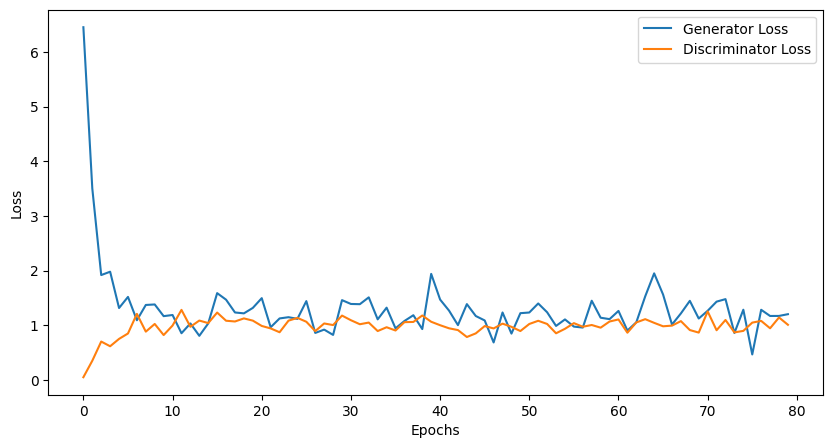

In [21]:
plot_losses(losses_G, losses_D)

## Evaluating the Model

###  Load the MNIST Test Dataset

In [22]:
batch_size = 64
mnist_test_dataset = datasets.MNIST(root="./data/test", train=False, download=True, transform=transform)
test_dataloader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 112079923.13it/s]


Extracting ./data/test/MNIST/raw/train-images-idx3-ubyte.gz to ./data/test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43636777.31it/s]

Extracting ./data/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/test/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27478470.61it/s]


Extracting ./data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7568744.05it/s]

Extracting ./data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/test/MNIST/raw



#### Real Images

In [23]:
import torchvision.utils
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
os.makedirs("real_images", exist_ok=True)
for i, (images, labels) in enumerate(test_dataloader):
    for j in range(images.size(0)):
        img = transform(images[j].squeeze())
        filename = f"{i * batch_size + j}.png"
        img_path = os.path.join("real_images", filename)
        torchvision.utils.save_image(img, img_path)

In [24]:
real_images_path = "real_images"

#### Fake Images

In [25]:
num_samples = len(test_dataloader.dataset)
os.makedirs("fake_images", exist_ok=True)
with torch.no_grad():
    for i in range(num_samples // batch_size):
        z = generate_noise(batch_size)
        fake_batch = generator(z)
        for j in range(fake_batch.size(0)):
            img = transform(fake_batch[j].squeeze())
            filename = f"{i * batch_size + j}.png"
            img_path = os.path.join("fake_images", filename)
            torchvision.utils.save_image(img, img_path)

In [26]:
fake_images_path = "fake_images" 

### Calculate Fréchet Inception Distance (FID) Score

In [27]:
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=batch_size, dims=2048, device=device)
print(f"FID Score: {fid_value}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 154MB/s]
100%|██████████| 156/156 [00:40<00:00,  3.82it/s]


FID Score: 17.99406885381657
